In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from centrex_trajectories.data_structures import Acceleration, Velocities, Coordinates
from centrex_trajectories import propagate_trajectories
from centrex_trajectories.beamline_objects import Bore, LinearSection, ElectrostaticQuadrupoleLens
from centrex_trajectories.particles import TlF
from centrex_trajectories.random_generation import (
    generate_random_coordinates_normal_circle,
    generate_random_velocities_normal,
)

from centrex_tlf import states, hamiltonian
from centrex_trajectories.utils import fit_stark_potential

plt.rcParams.update({"font.size": 14})


In [2]:
in_to_m = 25.4e-3
R = 1.75 * in_to_m / 2
n_trajectories = 50
particle = TlF()

lens_length = 2.0


# Generate Stark Shift

In [3]:
# generate states up to J=9
QN = states.generate_uncoupled_states_ground(Js=np.arange(8))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)

# V/cm
Ez = np.linspace(0, 50e3, 101)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(V, QN)

# original eigenvectors used in tracking states as energies change order
V_track = V.copy()

# indices of the J=2, mJ=0 states focused by the lens
indices_J2_mJ0 = [
    idx for idx, s in enumerate(QN_states) if s.largest.J == 2 and s.largest.mJ == 0
]

indices_J012 = [idx for idx, s in enumerate(QN_states) if s.largest.J in [0, 1, 2]]

# empty array for storing energies
energies = np.empty([Ez.size, len(QN)], dtype=np.complex128)

# iterate over the electric field values
for idx, Ei in enumerate(Ez):
    Hi = Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3])
    E, V = np.linalg.eigh(Hi)

    # sort indices to keep the state order the same
    indices = np.argmax(np.abs(V_track.conj().T @ V), axis=1)
    energies[idx, :] = E[indices]
    V_track[:, :] = V[:, indices]

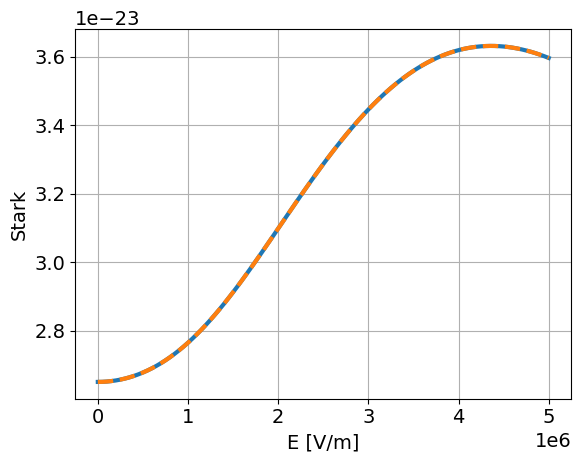

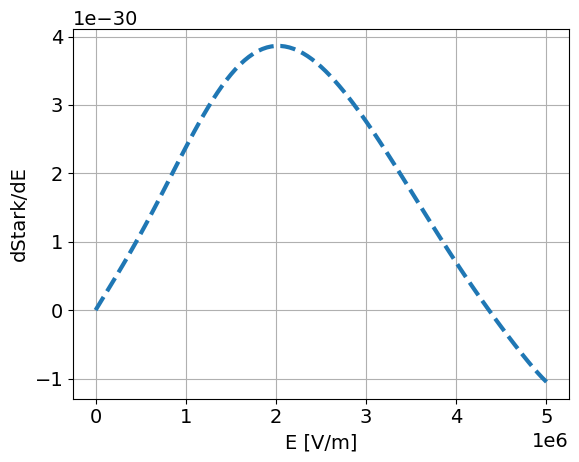

In [4]:
# convert to V/m
Ez_Vm = Ez * 100

# grab energy of J=2, mJ=0
energy = energies.real[:, indices_J2_mJ0[0]] * sp.constants.hbar

fit_coeff = fit_stark_potential(Ez_Vm, energy, deg=11)
fit = np.polynomial.Polynomial(coef=fit_coeff)

fig, ax = plt.subplots()
ax.plot(Ez_Vm, energy, lw=3)
ax.plot(Ez_Vm, fit(Ez_Vm), ls="--", lw=3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("Stark")
ax.grid(True)

fig, ax = plt.subplots()
# ax.plot(Ez_Vm, np.diff(energy) / np.diff(Ez_Vm), lw=3)
ax.plot(Ez_Vm, fit.deriv()(Ez_Vm), ls="--", lw=3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("dStark/dE")
ax.grid(True)

In [5]:
lens = ElectrostaticQuadrupoleLens(
    name="Lens",
    objects=[],
    start=0.1,
    stop=0.1 + lens_length,
    V=30_000,
    R=R,
    stark_potential=fit_coeff,
)

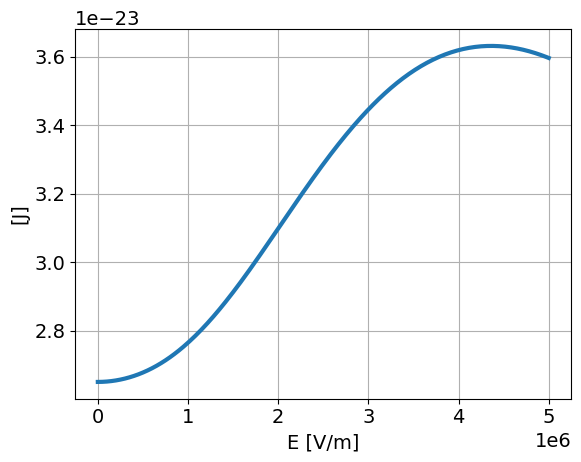

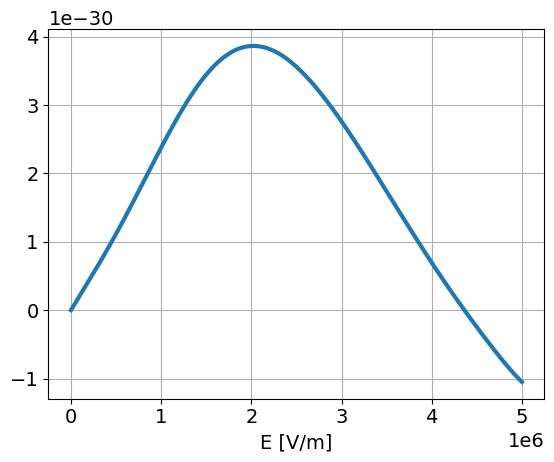

In [6]:
x = np.linspace(0, 5e6, 301)

fig, ax = plt.subplots()
ax.plot(x, lens.stark_potential_E(x), lw=3)
ax.set_xlabel("E [V/m]")
ax.set_ylabel("[J]")
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(x, lens.stark_potential_E_derivative(x), lw=3)
ax.set_xlabel("E [V/m]")
ax.grid(True)

# Extract spring constant

3.472848959621723e-20

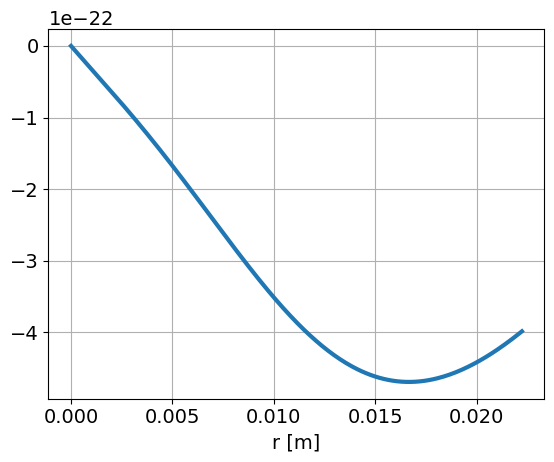

In [7]:
r = np.linspace(0, R, x.size)
force = np.array([lens.force(0.0, ri, 0.0, 0.0)[0] for ri in r])
fig, ax = plt.subplots()
ax.plot(r, force, lw=3)
ax.set_xlabel("r [m]")
ax.set_ylabel("")
ax.grid(True)

k = abs(float(force[len(force)//2] / r[len(force)//2]))
k
# k = abs(force[np.argmin(force)] / r[np.argmin(force)])
# k

# Test for random initial conditions

In [8]:
coords = generate_random_coordinates_normal_circle(2e-3, n_trajectories)

velocities = generate_random_velocities_normal(
    vx=0.0,
    vy=0.0,
    vz=184.0,
    sigma_vx=4.0,
    sigma_vy=4.0,
    sigma_vz=16.5,
    number=n_trajectories,
)


In [9]:
bore = Bore(x=0.0, y=0.0, z = 0.1, length = lens_length, radius=R)
eql_analytical = LinearSection(
    name="EQL",
    objects=[bore],
    start = 0.1,
    stop = 0.1 + lens_length,
    save_collisions=False,
    spring_constant=(k, k, 0.0)
)
lens = ElectrostaticQuadrupoleLens(
    name="Lens",
    objects=[bore],
    start=0.1,
    stop=0.1 + lens_length,
    V=30_000,
    R=R,
    stark_potential=fit_coeff,
    save_collisions=True
)

sections = [eql_analytical]
sections_ode = [lens]

In [10]:
section_data, trajectories = propagate_trajectories(
    sections, coords, velocities, particle, z_save = np.linspace(0.1, 0.1 + lens_length, 101)
)

section_data_ode, trajectories_ode = propagate_trajectories(
    sections_ode, coords, velocities, particle
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    3.4s finished


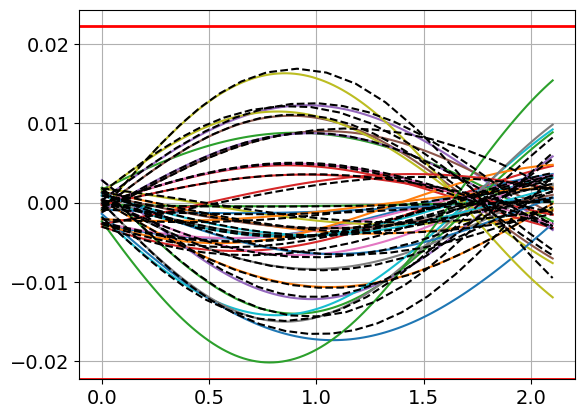

In [11]:
fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, traj.y)

for traj in trajectories_ode.values():
    ax.plot(traj.z, traj.y, ls = '--', color = 'k')

ax.axhline(R, color = 'r', lw = 2)
ax.axhline(-R, color = 'r', lw = 2)

ax.grid()

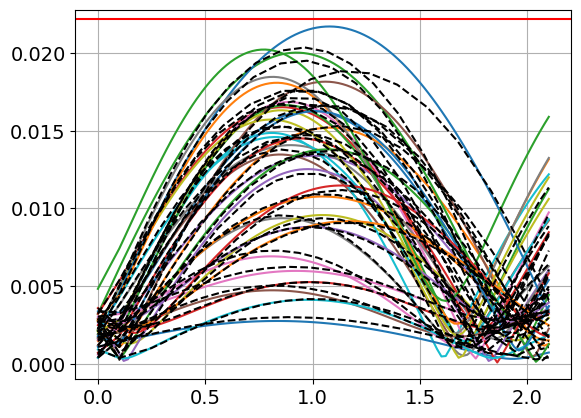

In [12]:
fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, np.sqrt(traj.x**2+ traj.y**2))

for traj in trajectories_ode.values():
    ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')

# for traj in trajectories_ode_nb.values():
#     ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')

ax.axhline(R, color = 'r')
ax.grid()

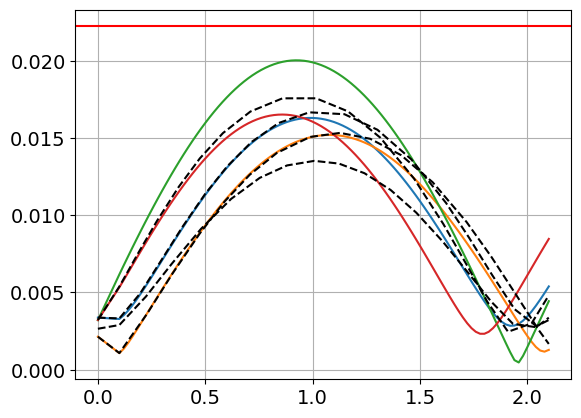

In [13]:
fig, ax = plt.subplots()

for idt, traj in enumerate(trajectories.values()):
    ax.plot(traj.z, np.sqrt(traj.x**2+ traj.y**2))
    if idt >= 3:
        break

for idt, traj in enumerate(trajectories_ode.values()):
    ax.plot(traj.z, np.sqrt(traj.x**2 + traj.y**2), ls = '--', color = 'k')
    if idt >= 3:
        break

ax.axhline(R, color = 'r')
ax.grid()

# Test Straight line trajectory with gravity

In [14]:
start = Coordinates(np.array([0.0, 0.0]), np.array([0.0, 0.0]), np.array([0.0, 0.0]))
vels = Velocities(np.array([0.0, 0.0]), np.array([0.0, 0.0]), np.array([184.0, 184.0]))

In [15]:
section_data, trajectories = propagate_trajectories(
    sections, start, vels, particle, z_save = np.linspace(0.1, 0.1 + lens_length, 101)
)

section_data_ode, trajectories_ode = propagate_trajectories(
    sections_ode, start, vels, particle
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


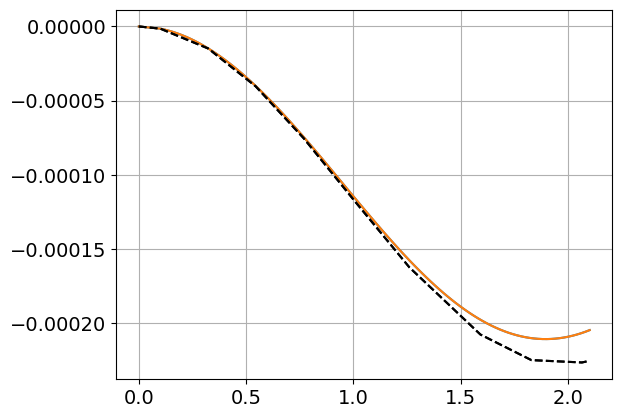

In [16]:
fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, traj.y)

for traj in trajectories_ode.values():
    ax.plot(traj.z, traj.y, ls = '--', color = 'k')


ax.grid()

# Test y offset for bore and lens

In [17]:
y_offset = R/2
bore = Bore(x=0.0, y=y_offset, z = 0.1, length = lens_length, radius=R)
eql_analytical = LinearSection(
    name="EQL",
    objects=[bore],
    start = 0.1,
    stop = 0.1 + lens_length,
    save_collisions=False,
    spring_constant=(k, k, 0.0),
    y = y_offset
)
lens = ElectrostaticQuadrupoleLens(
    name="Lens",
    objects=[bore],
    start=0.1,
    stop=0.1 + lens_length,
    V=30_000,
    R=R,
    stark_potential=fit_coeff,
    save_collisions=True,
    y = y_offset
)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.0s finished


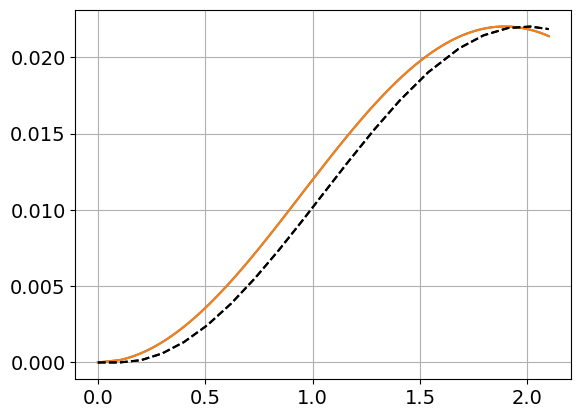

In [18]:
section_data, trajectories = propagate_trajectories(
    [eql_analytical], start, vels, particle, z_save = np.linspace(0.1, 0.1 + lens_length, 101)
)

section_data_ode, trajectories_ode = propagate_trajectories(
    [lens], start, vels, particle
)

fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, traj.y)

for traj in trajectories_ode.values():
    ax.plot(traj.z, traj.y, ls = '--', color = 'k')


ax.grid()

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


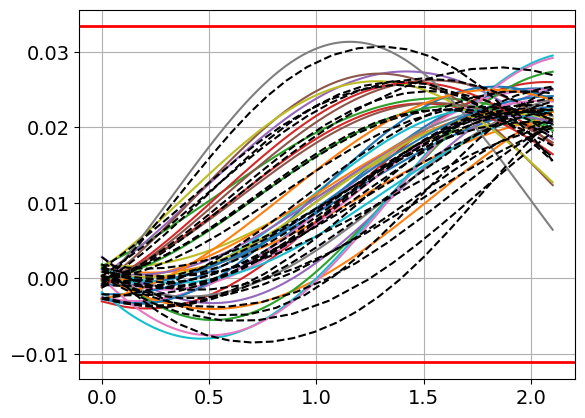

In [19]:
section_data, trajectories = propagate_trajectories(
    [eql_analytical], coords, velocities, particle, z_save = np.linspace(0.1, 0.1 + lens_length, 101)
)

section_data_ode, trajectories_ode = propagate_trajectories(
    [lens], coords, velocities, particle
)

fig, ax = plt.subplots()

for traj in trajectories.values():
    ax.plot(traj.z, traj.y)

for traj in trajectories_ode.values():
    ax.plot(traj.z, traj.y, ls = '--', color = 'k')

ax.axhline(R + y_offset, color = 'r', lw = 2)
ax.axhline(-R + y_offset, color = 'r', lw = 2)

ax.grid()

# Test with CeNTREX beamline

In [20]:
from typing import Tuple, List
import numpy.typing as npt

from centrex_trajectories.beamline_objects import Section, CircularAperture, PropagationType, RectangularAperture
from centrex_trajectories.propagation import PropagationOptions
from centrex_trajectories import Gravity
from centrex_trajectories.data_structures import Trajectories, SectionData

In [21]:
options = PropagationOptions(verbose=False, n_cores=8)
particle = TlF()
gravity = Gravity(0, -9.81 * particle.mass, 0)

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 3

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_radius = 0.011


# acme freezing distribution modified to our cell opening size (0.25" vs 5 mm for ACME)
sigma_x = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution
sigma_y = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution

In [22]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=rc_aperture_radius,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[
        # CircularAperture(0, 0, bbexit.stop + 19.6 * in_to_m, R * 1.2),
        # CircularAperture(
        #     0,
        #     0,
        #     bbexit.stop + (19.6 + 0.375 + 9.625) * in_to_m,
        #     R * 1.2,
        # ),
    ],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = ElectrostaticQuadrupoleLens(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            +  + 10.5 * in_to_m
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)

In [23]:
def lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    voltage: float,
    detection_laser_distance: float,
    detection_aperture_distance: float,
    length: float = 0.6,
    radius: float = 0.022225,
    stark_potential: npt.NDArray[np.float64] = fit_coeff,
    lens_type: str = "ODE"
) -> Tuple[List[SectionData], Trajectories, List[Section]]:
    if lens_type == "ODE":
        eql = ElectrostaticQuadrupoleLens(
            name="Electrostatic Lens",
            objects=[
                Bore(
                    x=0,
                    y=0,
                    z=bbexit.stop
                    + distance_lens_bbexit
                    + (lens_chamber_length - lens_electrode_length) / 2,
                    length=lens_electrode_length,
                    radius=radius,
                )
            ],
            start=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            stop=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2
            + length,
            V=voltage,
            R=radius,
            save_collisions=False,
            stark_potential=stark_potential,
        )
    elif lens_type == "LINEAR":
        k_new = k * voltage / 30e3
        eql = LinearSection(
            name="EQL",
            objects=[
                Bore(
                    x=0,
                    y=0,
                    z=bbexit.stop
                    + distance_lens_bbexit
                    + (lens_chamber_length - lens_electrode_length) / 2,
                    length=lens_electrode_length,
                    radius=radius,
                )
            ],
            start=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            stop=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2
            + length,
            save_collisions=False,
            spring_constant=(k_new, k_new, 0.0),
        )

    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + detection_aperture_distance,
                wx,
                wy,
            )
        ],
        start=eql.stop + detection_aperture_distance - 1e-3,
        stop=eql.stop + detection_laser_distance,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [24]:
n_trajectories = 20_000_000

origin = Coordinates(
    x=np.random.randn(n_trajectories) * sigma_x,
    y=np.random.randn(n_trajectories) * sigma_y,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

k=np.float64(2.374725862884119e-20)


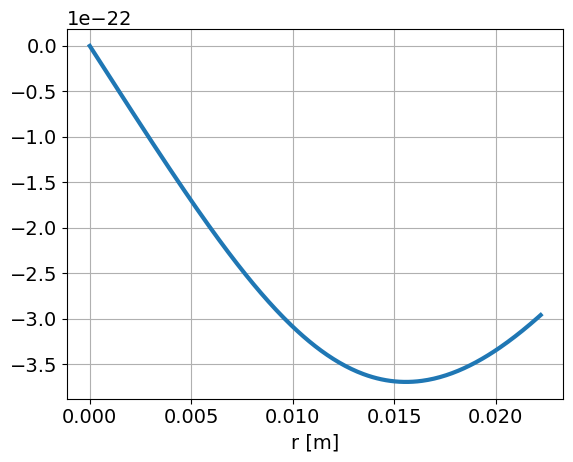

In [65]:
r = np.linspace(0, R, x.size)
force = np.array([lens.force(0.0, ri, 0.0, 0.0)[0] for ri in r])
fig, ax = plt.subplots()
ax.plot(r, force, lw=3)
ax.set_xlabel("r [m]")
ax.set_ylabel("")
ax.grid(True)

# k = abs(float(force[len(force)//2] / r[len(force)//2]))
# k
k = abs(force[np.argmin(force)] / r[np.argmin(force)])
print(f"{k=}")

In [66]:
from rich import progress

voltages = np.array(
    [10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
) * 1e3

data_linear = []
with progress.Progress(
    progress.TextColumn("[progress.description]{task.description}"),
    progress.BarColumn(bar_width=None),
    progress.TaskProgressColumn(),
    progress.MofNCompleteColumn(),
    progress.TimeElapsedColumn(),
    progress.TimeRemainingColumn(),
) as pb:
    t = pb.add_task("voltage", total=len(voltages))
    for idy, voltage in enumerate(voltages):
        data_linear.append(
            lens_scan_function(
                origin,
                velocities,
                voltage,
                detection_laser_distance=lens_reducer_flange
                + n_nipples * nipple_length
                + 10.5 * in_to_m
                + distance_det_center,
                detection_aperture_distance=lens_reducer_flange
                + n_nipples * nipple_length
                + distance_det_center
                + 10.5 * in_to_m
                - 1 * in_to_m,
                stark_potential=fit_coeff,
                lens_type="LINEAR",
            )
        )
        pb.advance(task_id=t, advance=1)
        pb.refresh()


Output()

In [27]:
from rich import progress

voltages = np.array(
    [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
) * 1e3

data_ode = []
with progress.Progress(
    progress.TextColumn("[progress.description]{task.description}"),
    progress.BarColumn(bar_width=None),
    progress.TaskProgressColumn(),
    progress.MofNCompleteColumn(),
    progress.TimeElapsedColumn(),
    progress.TimeRemainingColumn(),
) as pb:
    t = pb.add_task("voltage", total=len(voltages))
    for idy, voltage in enumerate(voltages):
        data_ode.append(
            lens_scan_function(
                origin,
                velocities,
                voltage,
                detection_laser_distance=lens_reducer_flange
                + n_nipples * nipple_length
                + 10.5 * in_to_m
                + distance_det_center,
                detection_aperture_distance=lens_reducer_flange
                + n_nipples * nipple_length
                + distance_det_center
                + 10.5 * in_to_m
                - 1 * in_to_m,
                stark_potential=fit_coeff,
                lens_type="ODE",
            )
        )
        pb.advance(task_id=t, advance=1)
        pb.refresh()


Output()

In [67]:
voltages = np.array(
    [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
) * 1e3
data_linear_fixed = [data_ode[0]] + data_linear

In [68]:
nr_survived = [len(d[1]) for d in data_linear_fixed]
nr_survived_ode = [len(d[1]) for d in data_ode]

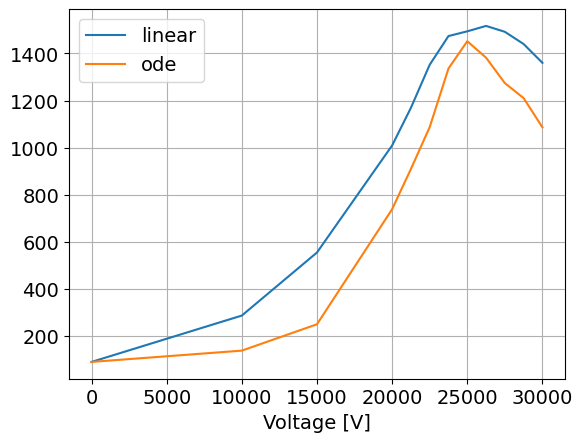

In [69]:
fig, ax = plt.subplots()

ax.plot(voltages, nr_survived, label="linear")
ax.plot(voltages, nr_survived_ode, label="ode")
ax.set_xlabel("Voltage [V]")
ax.legend()
ax.grid()